In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import PIL
from io import BytesIO
from PIL import Image
import os
import random
from collections import Counter
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from enum import Enum
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.measure import block_reduce
from sklearn.decomposition import PCA
import seaborn as sns

# Preprocessing:

*   Decode encoded images
*   Flatten and check number of images



In [ ]:
r = open(f'/content/drive/My Drive/ISYE 6740/Midjourney/Encoded Images.txt')
midjourney_images = [np.asarray(json.JSONDecoder().decode(line)).astype('uint8') for line in r]
r = open(f'/content/drive/My Drive/ISYE 6740/Stable Diffusion/Encoded Images.txt')
stable_images = [np.asarray(json.JSONDecoder().decode(line)).astype('uint8') for line in r]
r = open(f'/content/drive/My Drive/ISYE 6740/DALL-E/Encoded Images.txt')
dalle_images = [np.asarray(json.JSONDecoder().decode(line)).astype('uint8') for line in r]

In [ ]:
class ImageBot(Enum):
  DALLE = 0
  MID = 1
  STABLE = 2

In [ ]:
flat_midjourney = [im.flatten() for im in midjourney_images if len(im.flatten()) == 12288]
flat_stable = [im.flatten() for im in stable_images if len(im.flatten()) == 12288]
flat_dalle = [im.flatten() for im in dalle_images if len(im.flatten()) == 12288]
#print(Counter([len(im) for im in flat_midjourney]))
#print(Counter([len(im) for im in flat_stable]))
#print(Counter([len(im) for im in flat_dalle]))

# Sampling and Labeling Data


*   Randomly select 9000 images from each generator
*   Attach true class labels to each image
*   80% train 20% test split



In [ ]:
flat_gens = [flat_midjourney, flat_stable, flat_dalle]
X = []
for gen in flat_gens: 
  sample_idx = random.sample(range(len(gen)), 9000)
  X += [gen[ix] for ix in sample_idx]
X = np.array(X) 

y = np.array([ImageBot.MID.value] * 9000 + [ImageBot.STABLE.value] * 9000 + [ImageBot.DALLE.value] * 9000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Naive Bayes

              precision    recall  f1-score   support

           0       0.79      0.52      0.63      1800
           1       0.52      0.69      0.59      1800
           2       0.62      0.62      0.62      1800

    accuracy                           0.61      5400
   macro avg       0.64      0.61      0.61      5400
weighted avg       0.64      0.61      0.61      5400



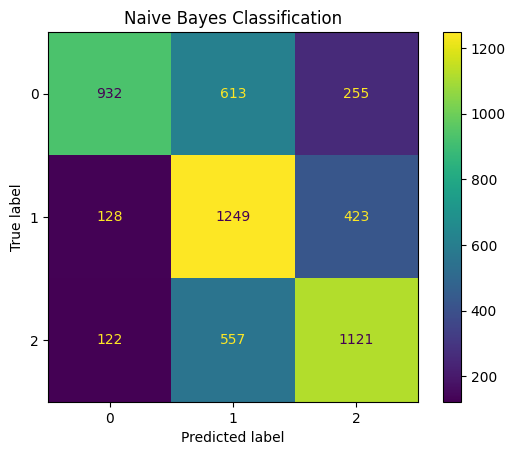

In [ ]:
nb = GaussianNB().fit(X_train, y_train)
NB_pred = nb.predict(X_test)
NB_cfm = confusion_matrix(y_test, NB_pred)
print(classification_report(y_test, NB_pred))
ConfusionMatrixDisplay(NB_cfm).plot()
plt.title("Naive Bayes Classification")
plt.show()

# Random Forest

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1800
           1       0.87      0.85      0.86      1800
           2       0.85      0.87      0.86      1800

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.90      5400
weighted avg       0.90      0.90      0.90      5400



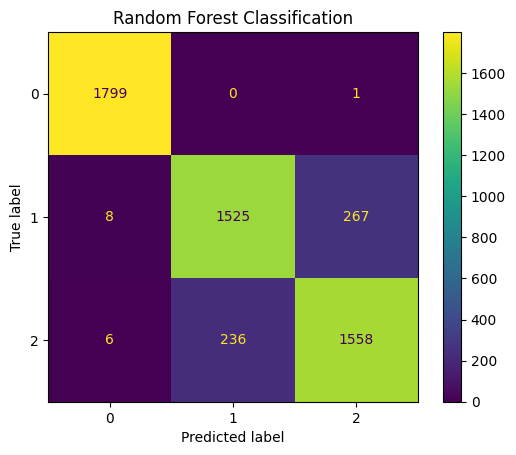

In [ ]:
rf = RandomForestClassifier().fit(X_train, y_train)
RF_pred = rf.predict(X_test)
print(classification_report(y_test, RF_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, RF_pred)).plot()
plt.title("Random Forest Classification")
plt.show()

# K Nearest Neighbors

*   Downsample
*   Tune number of neighbors for best performance
*   Hold-out method (80-20) using GridSearchCV for best K
*   5-fold cross validation method



In [ ]:
# Downsampling from 64x64 to 32x32
X_train_ds = [np.ravel(block_reduce(image.reshape((64, 64, 3)), block_size=(2, 2, 1), func=np.mean)) for image in X_train]
X_test_ds = [np.ravel(block_reduce(image.reshape((64, 64, 3)), block_size=(2, 2, 1), func=np.mean)) for image in X_test]

In [ ]:
#params = {'n_neighbors': np.arange(5, 51, 5)}
params = {'n_neighbors': np.arange(1, 15)}
clf = GridSearchCV(KNeighborsClassifier(), params)
K = clf.fit(X_train_ds, y_train).best_estimator_.n_neighbors
print(f'Best number of neighbors: {K}')

Best number of neighbors: 2


**Hold-out:**

              precision    recall  f1-score   support

           0       0.63      0.49      0.55      1800
           1       0.70      0.50      0.58      1800
           2       0.54      0.81      0.65      1800

    accuracy                           0.60      5400
   macro avg       0.62      0.60      0.59      5400
weighted avg       0.62      0.60      0.59      5400



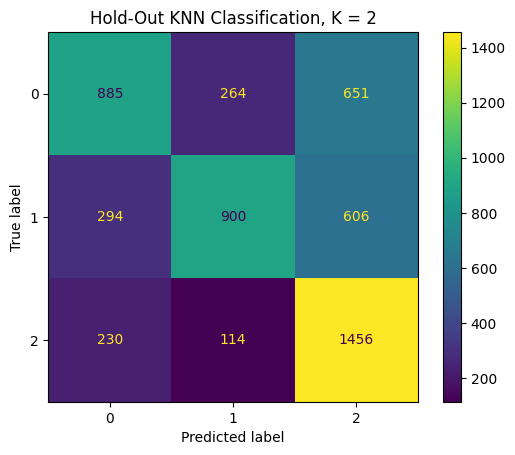

In [ ]:
KNN = KNeighborsClassifier(n_neighbors = K)
KNN_pred = KNN.fit(X_train_ds, y_train).predict(X_test_ds)
cfm = confusion_matrix(y_test, KNN_pred)
print(classification_report(y_test, KNN_pred))
ConfusionMatrixDisplay(cfm).plot()
plt.title(f'Hold-Out KNN Classification, K = {K}')
plt.show()

**5-Fold Cross Validation:**

In [ ]:
KNN_cv = KNeighborsClassifier(n_neighbors = K)
cv_scores = cross_val_score(KNN_cv, X, y, cv = 5)
print(f'Mean cross-validation score: {np.mean(cv_scores)}')

Mean cross-validation score: 0.581037037037037


# Support Vector Machine

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1800
           1       0.91      0.77      0.83      1800
           2       0.78      0.85      0.81      1800

    accuracy                           0.84      5400
   macro avg       0.84      0.84      0.84      5400
weighted avg       0.84      0.84      0.84      5400



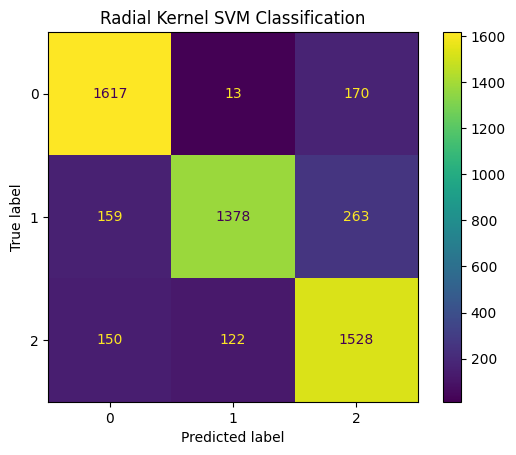

In [ ]:
svm = SVC(kernel="rbf").fit(X_train_ds, y_train)
SVM_pred = svm.predict(X_test_ds)
SVM_cfm = confusion_matrix(y_test, SVM_pred)
print(classification_report(y_test, SVM_pred))
ConfusionMatrixDisplay(SVM_cfm).plot()
plt.title("Radial Kernel SVM Classification")
plt.show()

# PCA

In [ ]:
## Full PCA didn't work, ran out of resources
#pca_full = PCA().fit(X)
pca_partial = PCA().fit(X_train_ds)

0.5201892982970333

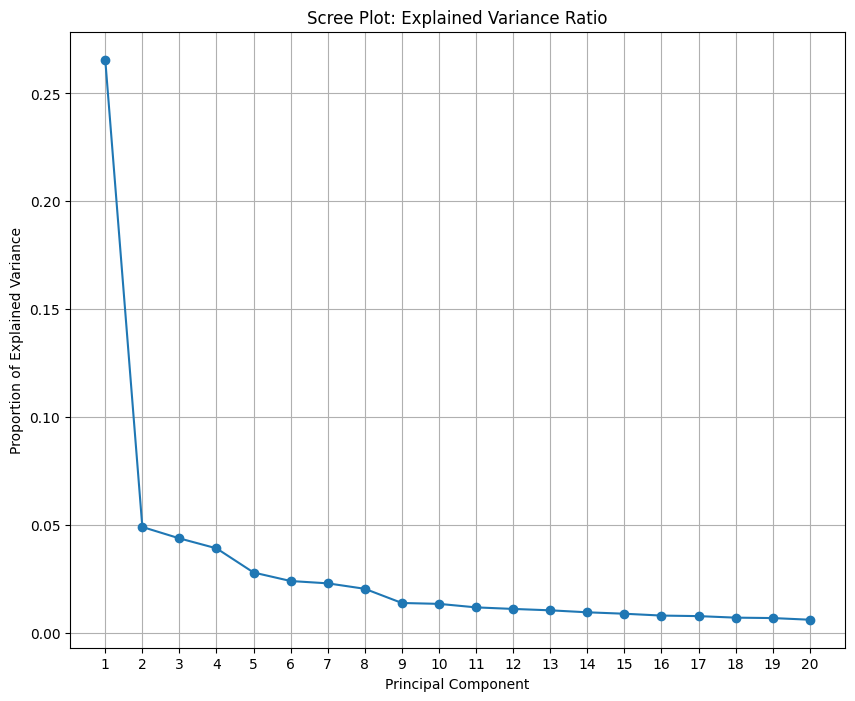

In [53]:
plt.figure(figsize = (10, 8))
plt.plot(np.arange(1, 21), pca_partial.explained_variance_ratio_[0:20], marker = "o")
plt.xticks(range(1, 21))
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Explained Variance")
plt.title("Scree Plot: Explained Variance Ratio")
plt.grid(True)
sum(pca_partial.explained_variance_ratio_[0:10])

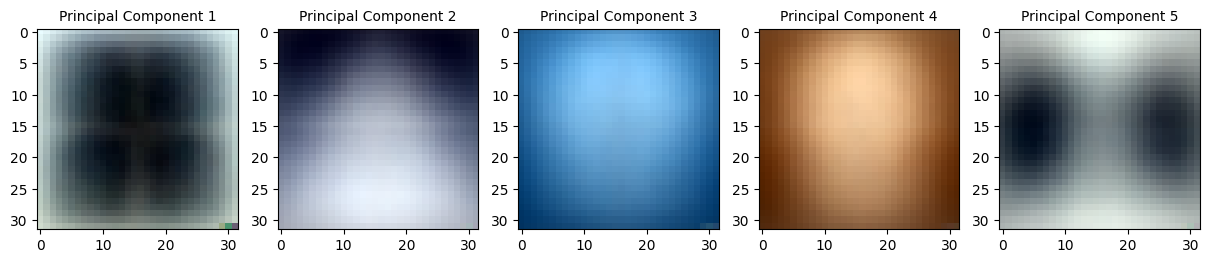

In [44]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))
for i in range(5):
  component = pca_partial.components_[i].reshape((32, 32, 3))
  component_range = np.max(component) - np.min(component)
  ax[i].set_title(f'Principal Component {i+1}', fontsize = 10)
  ax[i].imshow((component - np.min(component))/component_range)
plt.show()

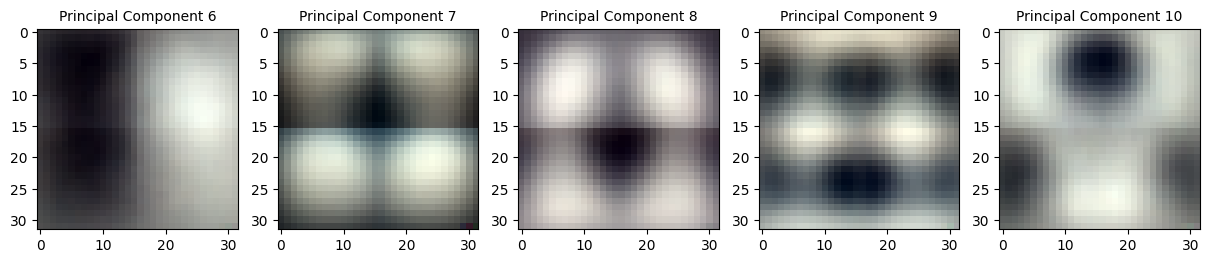

In [45]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))
for i in range(5):
  component = pca_partial.components_[5+i].reshape((32, 32, 3))
  component_range = np.max(component) - np.min(component)
  ax[i].set_title(f'Principal Component {i+1+5}', fontsize = 10)
  ax[i].imshow((component - np.min(component))/component_range)
plt.show()

# Re-run KNN and SVM on PCA-Transformed Data

In [48]:
principal_components_partial = pca_partial.components_[0:10] @ np.array(X_train_ds).T
X_test_principal_components = pca_partial.components_[0:10] @ np.array(X_test_ds).T

In [49]:
params = {'n_neighbors': np.arange(1, 15)}
clf = GridSearchCV(KNeighborsClassifier(), params)
K = clf.fit(principal_components_partial.T, y_train).best_estimator_.n_neighbors
print(f'Best number of neighbors: {K}')

Best number of neighbors: 14


              precision    recall  f1-score   support

           0       0.73      0.51      0.60      1800
           1       0.71      0.69      0.70      1800
           2       0.60      0.79      0.68      1800

    accuracy                           0.67      5400
   macro avg       0.68      0.67      0.66      5400
weighted avg       0.68      0.67      0.66      5400



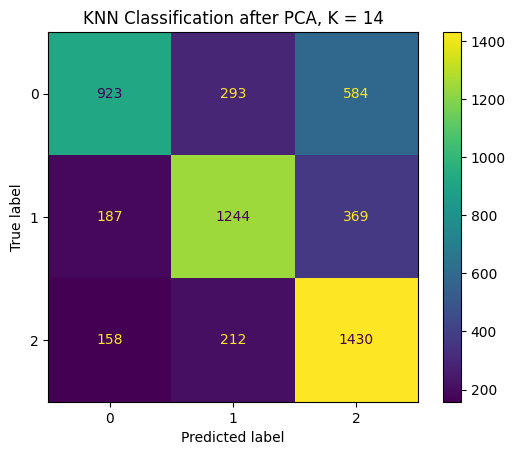

In [50]:
KNN = KNeighborsClassifier(n_neighbors = K)
KNN_pred = KNN.fit(principal_components_partial.T, y_train).predict(X_test_principal_components.T)
print(classification_report(y_test, KNN_pred))
cfm = confusion_matrix(y_test, KNN_pred)
ConfusionMatrixDisplay(cfm).plot()
plt.title(f"KNN Classification after PCA, K = {K}")
plt.show()

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1800
           1       0.75      0.60      0.67      1800
           2       0.60      0.82      0.69      1800

    accuracy                           0.67      5400
   macro avg       0.69      0.67      0.67      5400
weighted avg       0.69      0.67      0.67      5400



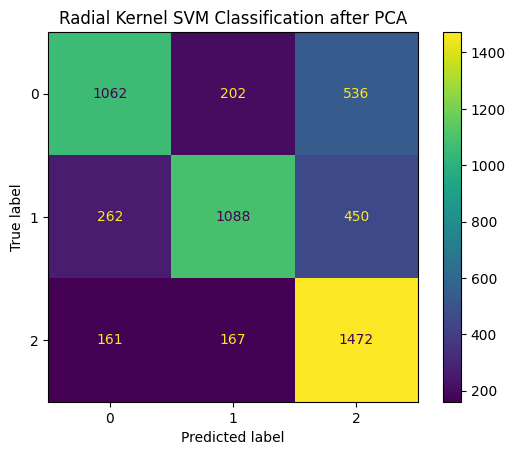

In [52]:
svm = SVC(kernel="rbf").fit(principal_components_partial.T, y_train)
SVM_pred = svm.predict(X_test_principal_components.T)
print(classification_report(y_test, SVM_pred))
SVM_cfm = confusion_matrix(y_test, SVM_pred)
ConfusionMatrixDisplay(SVM_cfm).plot()
plt.title("Radial Kernel SVM Classification after PCA")
plt.show()